# Python Conversion of Tracking Paper

In [6]:
import tensorflow as tf
import numpy as np
from scipy import signal
import cv2
import random

import os
import fnmatch

import math

import matplotlib.pyplot as plt

In [7]:
#undefined: see https://docs.opencv.org/2.4/modules/highgui/doc/reading_and_writing_images_and_video.html#videocapture-get
CV_CAP_PROP_FRAME_HEIGHT = 4
CV_CAP_PROP_FRAME_WIDTH = 3
CV_CAP_PROP_FRAME_COUNT = 7
CV_CAP_PROP_FPS = 5

## Soma Marking

### Parameters

In [50]:
# parameters 
# video_file = 'RgCo14.1.16cellneurons4long120s.avi'
thres_pix = 70 #threshold for amplitude of one pixel(70 is optimal)
Siz_pix = 1                          # unit size: pixels * pixels(1/2/5/10)

### Load video

In [51]:
root = 'data\\soma\\'
filename = 'blood_flow2.avi'

cap = cv2.VideoCapture(root+filename)

# Check if camera opened successfully
if (cap.isOpened()== False): 
    print("Error opening video stream or file")

if(cap.isOpened()):
    frame_height = cap.get(CV_CAP_PROP_FRAME_HEIGHT)
    frame_width = cap.get(CV_CAP_PROP_FRAME_WIDTH)
    frame_count = cap.get(CV_CAP_PROP_FRAME_COUNT)
    fps = cap.get(CV_CAP_PROP_FPS)
    
    M = frame_height*frame_width
    
    print(frame_count)

count = 0
key_frames = []
    
while(cap.isOpened()):
    ret, frame = cap.read()

    if ret == True:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Display the resulting frame
        cv2.imshow('Frame',frame)
        
        # if(count % 14 == 0):
        if count >= 0: # Wack numbers...
            imagePath='{0}blood_flow2_{1}.jpg'.format(root, count)
            cv2.imwrite(imagePath,frame)
            key_frames.append(frame)
 
        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    # Break the loop
    else: 
        break
    
    count += 1
        
# When everything done, release the video capture object
cap.release()
 
# Closes all the frames
cv2.destroyAllWindows()

100.0


#### Apply gaussian blurring

In [52]:
kernal_size = 5
sigma = 0

keyframes = []

for keyframe in key_frames:
    kf = cv2.GaussianBlur(keyframe,(kernal_size,kernal_size),sigma)
    keyframes.append(kf)

key_frames = keyframes

### Define Structure for reading results

In [53]:
image_array = []    

### Crop and normalize images

In [194]:
# Predefined subregion - Not used because video is much smaller?

start_x = 190
end_x = 459

start_y = 82
end_y = 401

for keyframe in key_frames:
    crop_img = keyframe[start_y:end_y, start_x:end_x] # Maybe order should be swapped?
    cv2.imshow("cropped", crop_img)
    cv2.waitKey(0)
    normalizedImg = np.zeros(cv2.getSize(crop_img))
    cv2.normalize(crop_img, normalizedImg, 0, 255, cv2.NORM_MINMAX)
    cv2.imshow('dst_rt', normalizedImg)
    cv2.waitKey(0)
    
    image_array.append(normalizedImg)

KeyboardInterrupt: 

100
(346, 296)


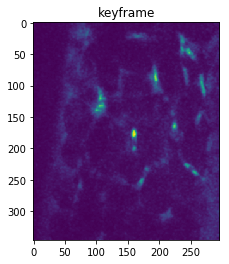

In [54]:
for keyframe in key_frames:
    h, w, c = keyframe.shape
    
    gray = cv2.cvtColor(keyframe, cv2.COLOR_BGR2GRAY)
    
    normalizedImg = np.zeros((w,h))
    normalizedImg = cv2.normalize(gray, normalizedImg, 0, 255, cv2.NORM_MINMAX)
    
    pad_y = (math.ceil(w/Siz_pix)*Siz_pix)-w
    pad_x = (math.ceil(h/Siz_pix)*Siz_pix)-h
    
    padded = np.pad(normalizedImg, ((0,pad_x),(0,pad_y)), 'constant', constant_values=(0))
    
    plt.imshow(padded)
    plt.title('keyframe')
    plt.show
    
    h, w = padded.shape
    image_array.append(padded)
    
padded_h = padded.shape[0]
padded_w = padded.shape[1]

print(len(image_array))
print(padded.shape)

#### Show sample keyframes

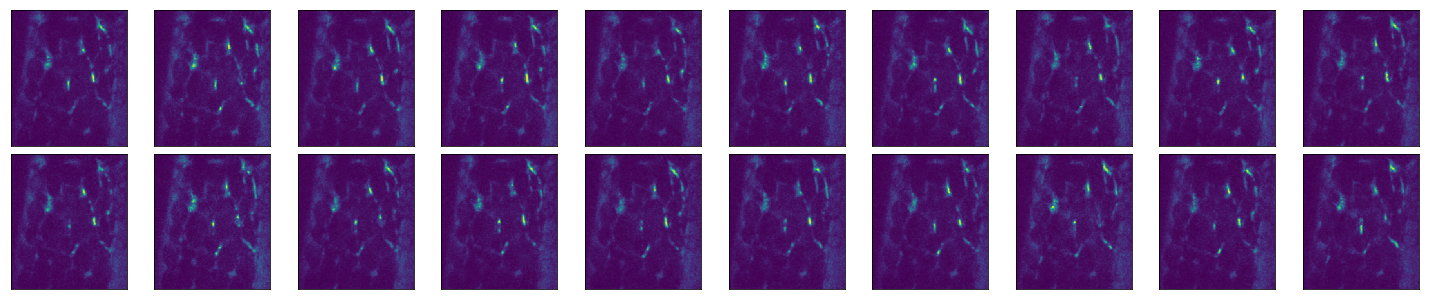

In [55]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = random.sample(image_array,20)

i = 0

for row in axes:
    for ax in row:
        ax.imshow(in_imgs[i].reshape((h,w)))
        i += 1
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

### Preprocess frames
#### Split frames

In [56]:
inten = []

i=[]

for image in image_array:
    frame = []
    f=[]
    num_w = 0
    num_h = 0
        
    for x in range(0, image.shape[0], Siz_pix):
        for y in range(0, image.shape[1], Siz_pix):
            block = image[x:x+Siz_pix,y:y+Siz_pix]
            
            frame.append(block)
            f.append(np.mean(block))
            num_h += 1
        num_w += 1
    inten.append(frame)
    i.append(f)
    
inten_array = np.array(inten)
print(inten_array.shape)

inten_low_rez = np.array(i)
print(inten_low_rez.shape)

(100, 102416, 1, 1)
(100, 102416)


### Reconstructed Block Image

<function matplotlib.pyplot.show>

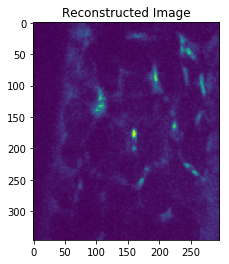

In [57]:
recon_low_rez = inten_low_rez.reshape(inten_low_rez.shape[0], int(padded_h/Siz_pix), int(padded_w/Siz_pix))

plt.imshow(recon_low_rez[-1])
plt.title('Reconstructed Image')
plt.show

### Signal Processing - Current serves no purpose?

In [200]:
fs = frame_count/120 # Old Sample frequency
fc = 4 # Cut off frequency

wN = 2*fc/fs # Original, different frame_count, so doesn't work
wN = 2*fc/fps # new version

B, A = signal.butter(12, wN,'low') # Butterworth filter
intensity_max = np.max(np.abs(inten_low_rez)) # Max overall

intensity_percent = np.divide(inten_low_rez, intensity_max)

y_lowz = signal.filtfilt(B,A,inten_low_rez)
per_lowz = signal.filtfilt(B,A,intensity_percent)

assert(len(y_lowz) == len(image_array))


### Find flashing regions

In [58]:
Train_inten_max = np.max(inten_low_rez, 0)
Train_inten_min = np.min(inten_low_rez, 0)

thres_unit = Siz_pix^2 * thres_pix

diff = Train_inten_max - Train_inten_min

print(diff.shape)

active_areas = []

for i in range(len(diff)):
    cell = diff[i]
    
    if cell > thres_unit:
        x = math.floor(i/(padded_w/Siz_pix))
        y = int(i % (padded_w/Siz_pix))
        
        active_areas.append((x,y))
        
print(len(active_areas))
            

(102416,)
5252


### Diplay Marked Areas

<function matplotlib.pyplot.show>

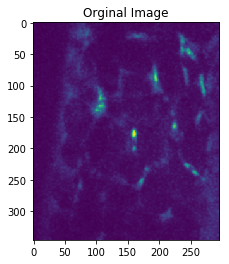

In [59]:
org = image_array[-1]

plt.imshow(org)
plt.title('Orginal Image')
plt.show

True

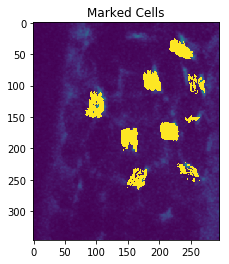

In [60]:
img = org.copy()

for cell in active_areas:
    start_x = cell[0]*Siz_pix
    end_x = start_x+Siz_pix
    start_y = cell[1]*Siz_pix
    end_y = start_y+Siz_pix

    img[start_x:end_x,start_y:end_y] = np.full((Siz_pix,Siz_pix),255)
    
plt.imshow(img)
plt.title('Marked Cells')
plt.show

imagePath='{0}marked_cells{1}.jpg'.format(root, count)
cv2.imwrite(imagePath,img)

## Blood cell tracking

In [35]:
# parameter for detecting cell
kernelSize      = 5               # size of LoG filter (unit: pixel) (depend on the scale of image)
kernelScale     = 1                # scale of LoG filter (unit: pixel) (depend on the scale of image)
threRatio       = 0.6              # threshod for detecting cell 
minSizeCell     = math.ceil(kernelSize*4)     # minimum size of cell

# parameters for optical flow
alpha = 0.04              # the regularization weight
ratio = 0.55               # the downsample ratio
minWidth = 5               # the width of the coarsest level
nOuterFPIterations = 7           # the number of outer fixed point iterations
nInnerFPIterations = 1               # the number of inner fixed point iterations
nSORIterations = 30                     # the number of SOR iterations

In [44]:
root = 'data\\cells_smooth\\'
filename = 'detectedcells0930.avi'

count = 0
key_frames = []

### Load Images

In [45]:
for file in os.listdir(root):
    if fnmatch.fnmatch(file, '*.jpg'):
        img = cv2.imread(root+"\\"+file,-1)
        key_frames.append(img)
        
print(len(key_frames))

480


### Load video

In [39]:
cap = cv2.VideoCapture(root+filename)

# Check if camera opened successfully
if (cap.isOpened()== False): 
    print("Error opening video stream or file")

if(cap.isOpened()):
    frame_height = cap.get(CV_CAP_PROP_FRAME_HEIGHT)
    frame_width = cap.get(CV_CAP_PROP_FRAME_WIDTH)
    frame_count = cap.get(CV_CAP_PROP_FRAME_COUNT)
    fps = cap.get(CV_CAP_PROP_FPS)
    
    M = frame_height*frame_width
    
    print(frame_count)
    
while(cap.isOpened()):
    ret, frame = cap.read()

    if ret == True:
        img = frame[30:589,85:596] # Crop out the border on the file
        
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Display the resulting frame
        cv2.imshow('Frame',img)
        
        imagePath='{0}frame_{1}.jpg'.format(root, count)
        cv2.imwrite(imagePath,img)
        
        # if(count % 14 == 0):
        if count >= 0: # Wack numbers...
            key_frames.append(img)
 
        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    # Break the loop
    else: 
        break
    
    count += 1
        
# When everything done, release the video capture object
cap.release()
 
# Closes all the frames
cv2.destroyAllWindows()

480.0


In [ ]:
### Process images

480
(559, 511, 3)


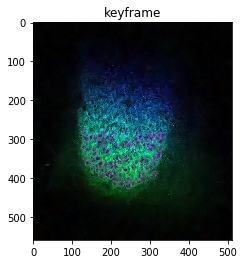

In [46]:
image_array = []

for keyframe in key_frames:
    h, w, c = keyframe.shape
    
    #gray = cv2.cvtColor(keyframe, cv2.COLOR_BGR2GRAY)
    
    normalizedImg = np.zeros((w,h))
    normalizedImg = cv2.normalize(keyframe, normalizedImg, 0, 255, cv2.NORM_MINMAX)
        
    plt.imshow(normalizedImg)
    plt.title('keyframe')
    plt.show
    
    h, w, c = normalizedImg.shape
    image_array.append(normalizedImg)
    
print(len(image_array))
print(normalizedImg.shape)

### Image Segmentation

### Locate cell

In [54]:
# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()
 
# Change thresholds
params.minThreshold = 10;
params.maxThreshold = 200;
 
# Filter by Area.
params.filterByArea = True
params.minArea = 30
 
# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.6
 
# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0.5
 
# Filter by Inertia
params.filterByInertia = True
params.minInertiaRatio = 0.5
 


True

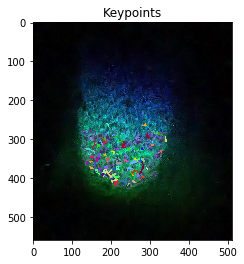

In [55]:
# Create a detector with the parameters
ver = (cv2.__version__).split('.')
if int(ver[0]) < 3 :
    detector = cv2.SimpleBlobDetector(params)
else : 
    detector = cv2.SimpleBlobDetector_create(params)

all_keypoints = []    
    
for im in image_array:    
    # Detect blobs.
    keypoints = detector.detect(im)
    all_keypoints.append(keypoints)
    
    # Draw detected blobs as red circles.
    # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
    im_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    # Display the resulting frame
    cv2.imshow('Frame',im_with_keypoints)
    
    # Press Q on keyboard to  exit
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break
# When everything done, release the video capture object
cap.release()
 
# Closes all the frames
cv2.destroyAllWindows()

plt.imshow(im_with_keypoints)
plt.title('Keypoints')
plt.show

imagePath='{0}cells_{1}.jpg'.format(root, count)
cv2.imwrite(imagePath,im_with_keypoints)

In [53]:
print(len(all_keypoints))

480


In [49]:
def dist(last_position, keypoint):
    return (abs(last_position[0]-keypoint.pt[0])+abs(last_position[1]-keypoint.pt[1]))

cells = []

frame_num = 0
flow_rate = 1

lines = []

# Create some random colors
color = np.random.randint(0,255,(100,3))

for frame in all_keypoints:
    for keypoint in frame:
        fit = None
        
        for cell in cells:
            last_position, last_frame = cell[-1]
            d = dist(last_position, keypoint)
            
            if d < flow_rate * min(frame_num, 10):
                if fit is not None:
                    old_d = dist(fit[-1][0], keypoint)
                    if d > old_d:
                        continue
                fit = cell
        
        int_pt = (int(keypoint.pt[0]),int(keypoint.pt[1]))
        if fit is None:
            cells.append([(int_pt, frame_num)])
        else:
            #img = cv2.add(image_array[frame_num], mask)
            fit.append((int_pt, frame_num))

    frame_num += 1
     

In [51]:
active_cells = []
mask = np.zeros_like(image_array[-1])

traceVid = image_array.copy()

print(len(traceVid))

for cell in cells:
    if len(cell) > 5:
        active_cells.append(cell)

print(len(active_cells))
        
for cell in active_cells:
    c = color[random.randint(0,99)].tolist()
    prev_line = None
    for line in cell:
        if prev_line is None:
            prev_line = line
            continue
            
        for i in range(prev_line[1], len(traceVid)):
            traceVid[i] = cv2.line(traceVid[i], prev_line[0], line[0], c, 2)
        prev_line = line

480
90


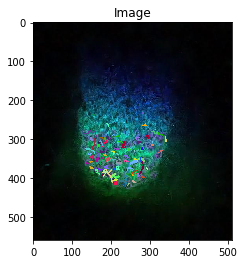

In [52]:
plt.imshow(traceVid[-1])
plt.title('Image')
plt.show  

imagePath='{0}trace{1}.jpg'.format(root, count)
cv2.imwrite(imagePath,mask)

# Create a VideoCapture object
cap = cv2.VideoCapture(0)
 
# Check if camera opened successfully
if (cap.isOpened() == False): 
    print("Unable to read camera feed")

# Default resolutions of the frame are obtained.The default resolutions are system dependent.
# We convert the resolutions from float to integer.
# frame_width = int(cap.get(3))
# frame_height = int(cap.get(4))
 
# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
out = cv2.VideoWriter('trace.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 10, (traceVid[0].shape[1], traceVid[0].shape[0]), True)

for img in traceVid:
    ret, frame = cap.read()
    
    # Write the frame into the file 'output.avi'
    out.write(img)
    
    cv2.imshow('Trace', img)
    if cv2.waitKey(10) & 0xFF == ord('q'): 
        break

# When everything done, release the video capture and video write objects
cap.release()
out.release()
 
# Closes all the frames
cv2.destroyAllWindows() 

In [31]:
blockSize = int(minSizeCell)
maxImgs = []

for img in image_array:
    num_h = 0
    num_w = 0
    
    max_img = thre.copy()
    
    # Non-maximum suppression
    for x in range(0, thre.shape[0], blockSize):
        for y in range(0, thre.shape[1], blockSize):
            block = thre[x:x+blockSize,y:y+blockSize]
            r, t = cv2.threshold(block, np.max(block)-0.01,0,cv2.THRESH_TOZERO)
            max_img[x:x+blockSize,y:y+blockSize] = t
            num_h += 1
        num_w += 1
    
    maxImgs.append(max_img)

NameError: name 'thre' is not defined

<function matplotlib.pyplot.show>

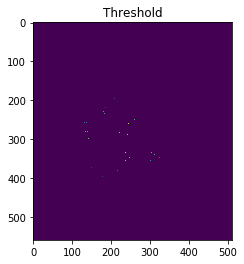

In [62]:
# maxImg = np.array(blockMax).reshape((len(image_array), math.ceil(thre.shape[0]/blockSize), math.ceil(thre.shape[1]/blockSize)))   
# print(maxImg.shape)

plt.imshow(maxImgs[5])
plt.title('Threshold')
plt.show

In [56]:
for img in maxImgs:
    cv2.imshow('Frame',img)
    
    # Press Q on keyboard to  exit
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break
# When everything done, release the video capture object
cap.release()
 
# Closes all the frames
cv2.destroyAllWindows()

<function matplotlib.pyplot.show>

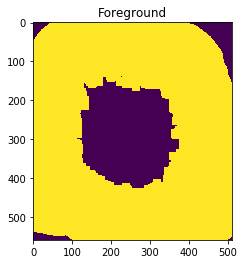

In [14]:
for img in image_array:
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) # Otsu binarisation
    
    # noise removal
    kernel = np.ones((kernelSize,kernelSize),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=3)
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    
    
plt.imshow(thresh)
plt.title('Threshold')
plt.imshow(unknown)
plt.title('Foreground')
plt.show

### Locate cell center

### Cell tracking

In [ ]:
thres = sqrt((283-281)^2+(326-313)^2)/5   # set a threshold for movement between frames 
xy1 = (281,326) # point 1 

In [116]:
# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()
 
# Change thresholds
params.minThreshold = 10;
params.maxThreshold = 200;
 
# Filter by Area.
params.filterByArea = True
params.minArea = 30
 
# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.6
 
# Filter by Convexity
params.filterByConvexity = False
params.minConvexity = 0.87
 
# Filter by Inertia
params.filterByInertia = True
params.minInertiaRatio = 0.5
 

In [ ]:
# Create a detector with the parameters
ver = (cv2.__version__).split('.')
if int(ver[0]) < 3 :
    detector = cv2.SimpleBlobDetector(params)
else : 
    detector = cv2.SimpleBlobDetector_create(params)

all_keypoints = []    
    
for im in image_array:    
    # Detect blobs.
    keypoints = detector.detect(im)
    all_keypoints.append([int(keypoints.pt[0]),int(keypoints.pt[1])])
    
    # Draw detected blobs as red circles.
    # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
    im_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    # Display the resulting frame
    cv2.imshow('Frame',im_with_keypoints)
    
    # Press Q on keyboard to  exit
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break
# When everything done, release the video capture object
cap.release()
 
# Closes all the frames
cv2.destroyAllWindows()

plt.imshow(im_with_keypoints)
plt.title('Keypoints')
plt.show

imagePath='{0}cells_{1}.jpg'.format(root, count)
cv2.imwrite(imagePath,im_with_keypoints)

In [110]:
cap = cv2.VideoCapture(root+filename)

# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0,255,(100,3))

# Take first frame and find corners in it
ret, old_frame = cap.read()
old_frame = old_frame[30:589,85:596]
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

p0 = cv2.

print(p0)

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

while(1):
    ret,frame = cap.read()
    
    if ret is False:
        break
    
    frame = frame[30:589,85:596] # Crop out the border on the file

    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Select good points
    good_new = p1[st==1]
    good_old = p0[st==1]

    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
        frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
    img = cv2.add(frame,mask)

    cv2.imshow('frame',img)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)

cv2.destroyAllWindows()
cap.release()

[[[233. 295.]]

 [[269. 295.]]

 [[271. 330.]]

 [[267. 339.]]

 [[243. 387.]]

 [[209. 316.]]

 [[267. 262.]]

 [[292. 303.]]

 [[226. 315.]]

 [[262. 366.]]

 [[262. 329.]]

 [[201. 269.]]

 [[232. 331.]]

 [[193. 255.]]

 [[239. 322.]]

 [[221. 333.]]

 [[250. 264.]]

 [[196. 282.]]

 [[254. 315.]]

 [[310. 296.]]

 [[152. 289.]]

 [[162. 272.]]

 [[250. 368.]]

 [[262. 355.]]

 [[209. 264.]]

 [[283. 253.]]

 [[252. 340.]]

 [[171. 245.]]

 [[208. 337.]]

 [[244. 284.]]

 [[230. 343.]]

 [[285. 331.]]

 [[252. 354.]]

 [[162. 297.]]

 [[284. 313.]]

 [[283. 295.]]

 [[245. 343.]]

 [[155. 312.]]

 [[173. 346.]]

 [[270. 372.]]

 [[252. 278.]]

 [[244. 372.]]

 [[255. 253.]]

 [[250. 295.]]

 [[143. 313.]]

 [[259. 302.]]

 [[151. 297.]]

 [[161. 208.]]

 [[192. 274.]]

 [[173. 278.]]

 [[215. 284.]]

 [[140. 271.]]

 [[294. 313.]]

 [[255. 376.]]

 [[168. 321.]]

 [[220. 356.]]

 [[316. 282.]]

 [[319. 304.]]

 [[204. 230.]]

 [[309. 268.]]

 [[269. 358.]]

 [[141. 289.]]

 [[240. 